### Verilerin Hazırlanması

Kütüphanelerin import edilmesi:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

Tüm araba resimlerini yeniden boyutlandırarak X değişkenini oluşturuyoruz.

In [2]:
IMAGE_SIZE = 224

In [3]:
img_dir = "../input/car-plate-detection/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

Tüm sınırlayıcı kutu açıklamalarını (etiket) içeren y değişkenini oluşturuyoruz. Bundan önce, ek açıklamaları, görüntülerin yeni boyutuna (200*200) uyacak şekilde yeniden boyutlandırmamız gerekecek. Bunun için bir fonksiyon resizeannotation oluşturuyoruz.

In [4]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [5]:
path = '../input/car-plate-detection/annotations'
text_files = ['../input/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [6]:
resizeannotation("../input/car-plate-detection/annotations/Cars147.xml")

[188, 141, 101, 104]

In [7]:
y[0]

[187, 144, 101, 104]

x ve y boyutunu kontrol ediyoruz

In [8]:
np.array(X).shape

(433, 224, 224, 3)

In [9]:
np.array(y).shape

(433, 4)

Ve veri setinin ilk on sekiz görüntüsünü gösteriyoruz:

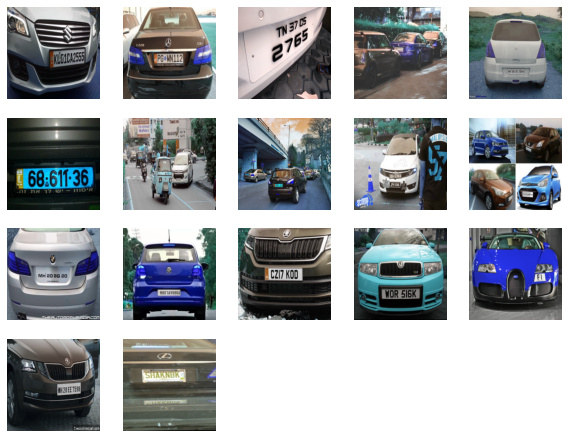

In [10]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

OpenCV kütüphanesini kullanarak plakanın bulunduğu dikdörtgeni çizebiliriz.

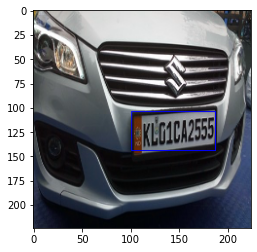

In [11]:
#Veri kümesinin ilk görüntüsüyle örnek
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

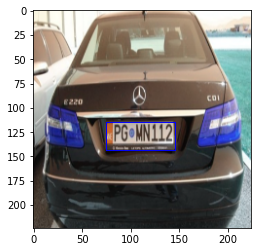

In [12]:
#Veri kümesinin ikinci görüntüsü ile örnek
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()

CNN için verileri hazırlıyoruz:

In [13]:
#Transforming in array - Dizide dönüştürme
X=np.array(X)
y=np.array(y)

In [14]:
#Renormalisation - yeniden normalleştirme
X = X / 255
y = y / 255

Veri setimizi ikiye böldük: eğitim seti/test seti

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

### Convolutionnal Neural Network

In [16]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Conv2D,MaxPooling2D,Dense
model = Sequential()
model.add(Conv2D(64 , (3,3) , input_shape=(224,224,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.1))

model.add(Conv2D(32 , (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='mean_squared_error',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)        0

In [17]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
11/11 [==============================] - 62s 5s/step - loss: 0.1239 - accuracy: 0.0743 - val_loss: 0.0315 - val_accuracy: 0.5641
Epoch 2/10
11/11 [==============================] - 49s 5s/step - loss: 0.0288 - accuracy: 0.4429 - val_loss: 0.0264 - val_accuracy: 0.5641
Epoch 3/10
11/11 [==============================] - 36s 3s/step - loss: 0.0211 - accuracy: 0.5314 - val_loss: 0.0264 - val_accuracy: 0.6410
Epoch 4/10
11/11 [==============================] - 46s 4s/step - loss: 0.0172 - accuracy: 0.6714 - val_loss: 0.0220 - val_accuracy: 0.6410
Epoch 5/10
11/11 [==============================] - 43s 4s/step - loss: 0.0118 - accuracy: 0.6857 - val_loss: 0.0195 - val_accuracy: 0.7436
Epoch 6/10
11/11 [==============================] - 35s 3s/step - loss: 0.0074 - accuracy: 0.7971 - val_loss: 0.0175 - val_accuracy: 0.8718
Epoch 7/10
11/11 [==============================] - 37s 3s/step - loss: 0.0044 - accuracy: 0.8686 - val_loss: 0.0169 - val_accuracy: 0.7436
Epoch 8/10
11/11 [==

In [18]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 75.00%


In [19]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

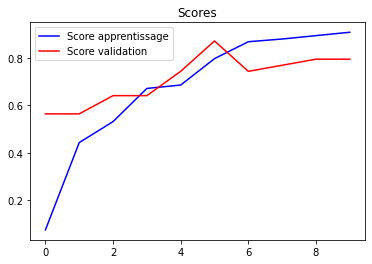

In [20]:
plot_scores(train)

### TESPİT ETME

In [21]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

100/100 [==============================] - 5s 49ms/step - loss: 0.0094 - accuracy: 0.7500
Test results 
 Loss: 0.0094344113022089 
 Accuracy 0.75


In [22]:
 y_cnn = model.predict(X_test)

Modelimizin plakaları nasıl yerelleştirdiğini test setimizde görebiliriz:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

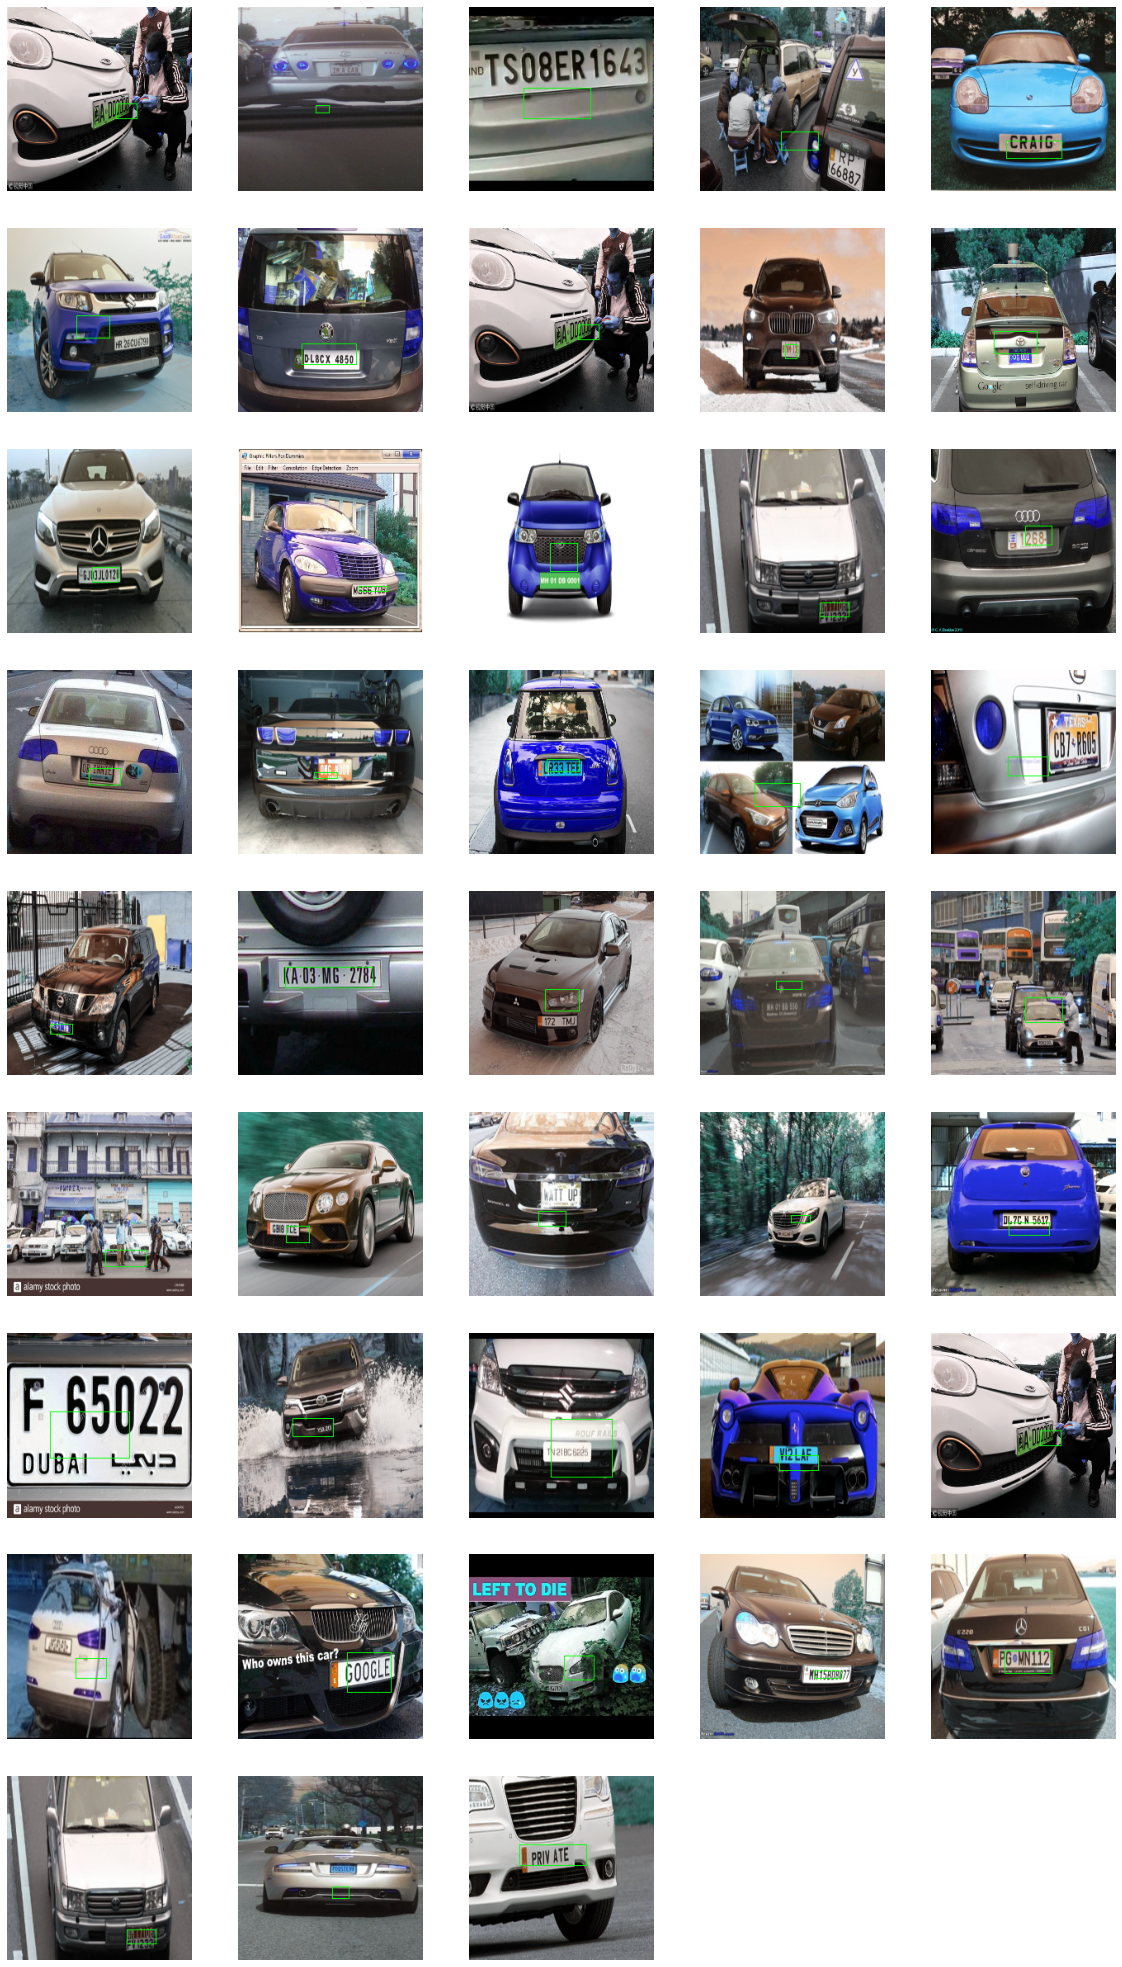

In [23]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)